In [4]:
from datasets import load_dataset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

print("✅ Entorno limpio y funcionando")

2025-10-30 05:35:04.116337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761802504.299479      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761802504.358733      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ Entorno limpio y funcionando


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

README.md:   0%|          | 0.00/721 [00:00<?, ?B/s]

data/train-00000-of-00004.parquet:   0%|          | 0.00/418M [00:00<?, ?B/s]

data/train-00001-of-00004.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

data/train-00002-of-00004.parquet:   0%|          | 0.00/385M [00:00<?, ?B/s]

data/train-00003-of-00004.parquet:   0%|          | 0.00/406M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/323M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Etiqueta: 0 | Imagen shape: (256, 256, 3)


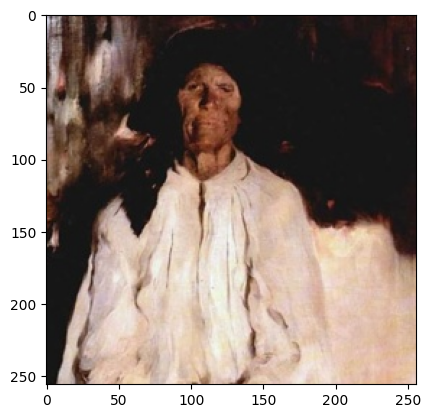

In [5]:
#Se carga el dataset desde HuggingFace
dataset = load_dataset("zguo0525/ArtBench")

#Se obtienen las divisiones
train_ds = dataset["train"]
test_ds = dataset["test"]

#Ejemplo
ej = train_ds[100]
img_array = np.array(ej["image"])
print("Etiqueta:", ej["label"], "| Imagen shape:", img_array.shape)
plt.imshow(img_array)
plt.show()

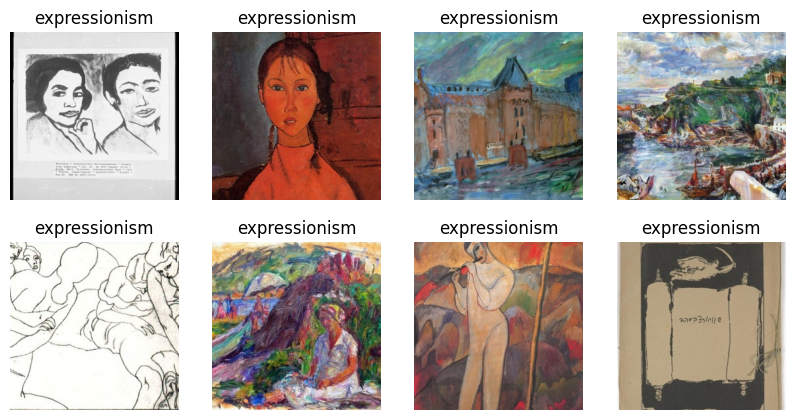

In [5]:
#Muestras del dataset

#Primero se hace el mapeo de labels.
class_names = train_ds.features["label"].names

fig, axes = plt.subplots(2, 4, figsize=(10,5))
for i, (example) in enumerate(dataset["train"].select(range(8))):
    img = example["image"]
    axes[i//4, i%4].imshow(img)
    axes[i//4, i%4].set_title(f"{class_names[example['label']]}")
    axes[i//4, i%4].axis("off")
plt.show()

In [7]:
IMG_SIZE = 224

#Se redimensionan a 224x224 y se normalizan [0,1]
def preprocess_tf(example):
    #Se realiza la siguiente conversión: PIL -> NumPy -> Tensor
    image = np.array(example["image"])
    image = tf.convert_to_tensor(image)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) #Redimensión
    image = tf.cast(image, tf.float32) / 255.0   # normalización [0,1]
    label = example["label"]
    return {"image": image, "label": label}

#Se aplica una transformación eficiente sin cargar todo a memoria
#Para que colab no explote c:
train_tf = dataset["train"].with_transform(preprocess_tf)
test_tf  = dataset["test"].with_transform(preprocess_tf)

#Se crean los nuevos datasets para Keras
tf_train = train_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64,
    shuffle=True
)

tf_test = test_tf.to_tf_dataset(
    columns="image",
    label_cols="label",
    batch_size=64
)

In [12]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models, optimizers
import keras

keras.backend.clear_session()

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Modelo base preentrenado (sin incluir la capa superior)
base_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Congelamos las capas base para no destruir los pesos de ImageNet al inicio
base_model.trainable = False

# Definimos la cabeza de clasificación
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)        # Evita actualizar BatchNorm
x = layers.GlobalAveragePooling2D()(x)          # Promedia los mapas de características
x = layers.Dropout(0.4)(x)                      # Regularización
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,047,754 (26.89 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [13]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    tf_train,
    validation_data=tf_test,
    epochs=15,
    callbacks=[early_stop]
)

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 389s 474ms/step - accuracy: 0.2893 - loss: 2.0344 - val_accuracy: 0.4894 - val_loss: 1.4538
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 352s 450ms/step - accuracy: 0.4155 - loss: 1.6124 - val_accuracy: 0.5007 - val_loss: 1.4119
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 361s 461ms/step - accuracy: 0.4210 - loss: 1.5922 - val_accuracy: 0.5001 - val_loss: 1.4023
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 366s 468ms/step - accuracy: 0.4286 - loss: 1.5804 - val_accuracy: 0.5018 - val_loss: 1.3953
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 365s 467ms/step - accuracy: 0.4324 - loss: 1.5748 - val_accuracy: 0.5028 - val_loss: 1.3890
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 326s 417ms/step - accuracy: 0.4295 - loss: 1.5761 - val_accuracy: 0.5052 - val_loss: 1.3808
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 364s 465ms/step - accuracy: 0.4301 - loss: 1.5706 - val_accuracy: 0.4945 - val_loss: 1.4086
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 359s 459ms/step - accuracy: 0.4276 -

In [14]:
base_model.trainable = True
for layer in base_model.layers[:250]:  # bloquea las primeras capas (opcional)
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history_fine = model.fit(
    tf_train,
    validation_data=tf_test,
    epochs=30,
    callbacks=[lr_scheduler, early_stop]
)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 457s 518ms/step - accuracy: 0.3983 - loss: 1.7843 - val_accuracy: 0.5322 - val_loss: 1.3154 - learning_rate: 1.0000e-05
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 402s 515ms/step - accuracy: 0.4688 - loss: 1.5115 - val_accuracy: 0.5513 - val_loss: 1.2606 - learning_rate: 1.0000e-05
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 397s 508ms/step - accuracy: 0.4935 - loss: 1.4184 - val_accuracy: 0.5642 - val_loss: 1.2271 - learning_rate: 1.0000e-05
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 404s 517ms/step - accuracy: 0.5063 - loss: 1.3745 - val_accuracy: 0.5757 - val_loss: 1.1922 - learning_rate: 1.0000e-05
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 403s 515ms/step - accuracy: 0.5312 - loss: 1.3128 - val_accuracy: 0.5782 - val_loss: 1.1809 - learning_rate: 1.0000e-05
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 399s 510ms/step - accuracy: 0.5348 - loss: 1.2689 - val_accuracy: 0.5875 - val_loss: 1.1490 - learning_rate: 1.0000e-05
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:
class_names = dataset["train"].features["label"].names
print(class_names)

['expressionism', 'art_nouveau', 'renaissance', 'ukiyo_e', 'realism', 'romanticism', 'surrealism', 'impressionism', 'baroque', 'post_impressionism']


In [ ]:
from tqdm import tqdm

y_true, y_pred = [], []

for images, labels in tqdm(tf_test, desc="Evaluando"):
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=class_names).plot(xticks_rotation=45, cmap="Blues")

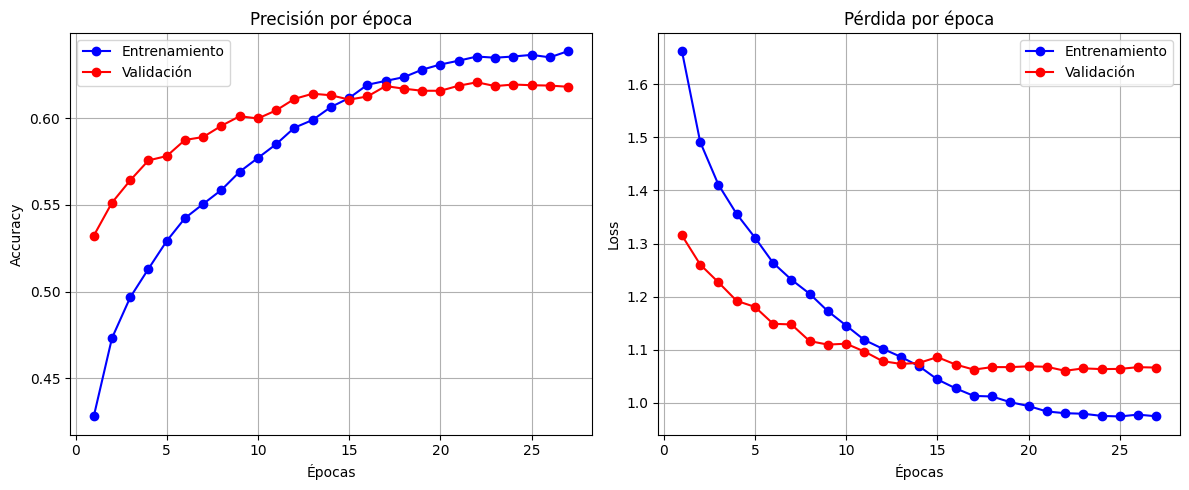

In [18]:
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Validación')
    plt.title('Precisión por época')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Validación')
    plt.title('Pérdida por época')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
plot_training(history_fine)